# Определение возраста покупателей

## Исследовательский анализ данных

In [20]:
# Загрузим необходимые библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
# Загрузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1/255)
gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=123
)

Found 7591 validated image filenames.


In [22]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [23]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [24]:
labels.shape

(7591, 2)

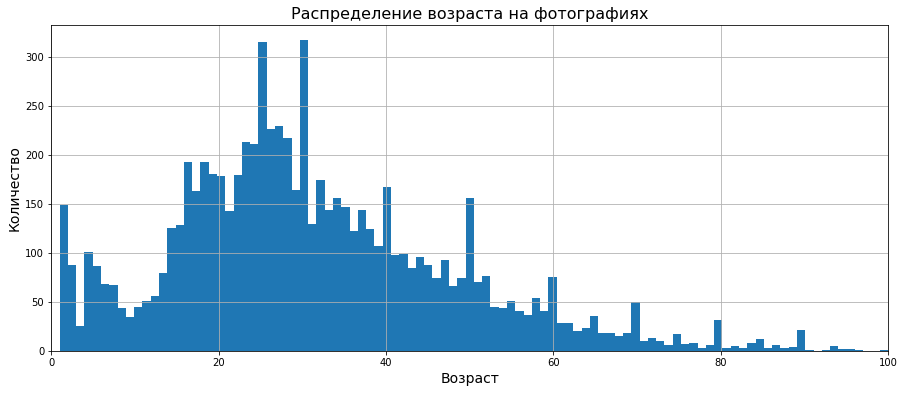

In [25]:
plt.figure(figsize=(15, 6))
labels['real_age'].plot(kind='hist', bins=100, grid=True)
plt.title('Распределение возраста на фотографиях', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xlim(0, 100)
plt.show()

In [26]:
print(f'''Самый маленький возраст - {labels['real_age'].min()}
Самый большой возраст - {labels['real_age'].max()}
Медианный возраст - {labels['real_age'].median()}''')

Самый маленький возраст - 1
Самый большой возраст - 100
Медианный возраст - 29.0


Из распределения возрастов по датасету мы видим, что больше всего фотографий людей в возрасте от 17 до 35 лет, медианный возраст составляет - 29 лет.

In [27]:
images, age = next(train_gen_flow)

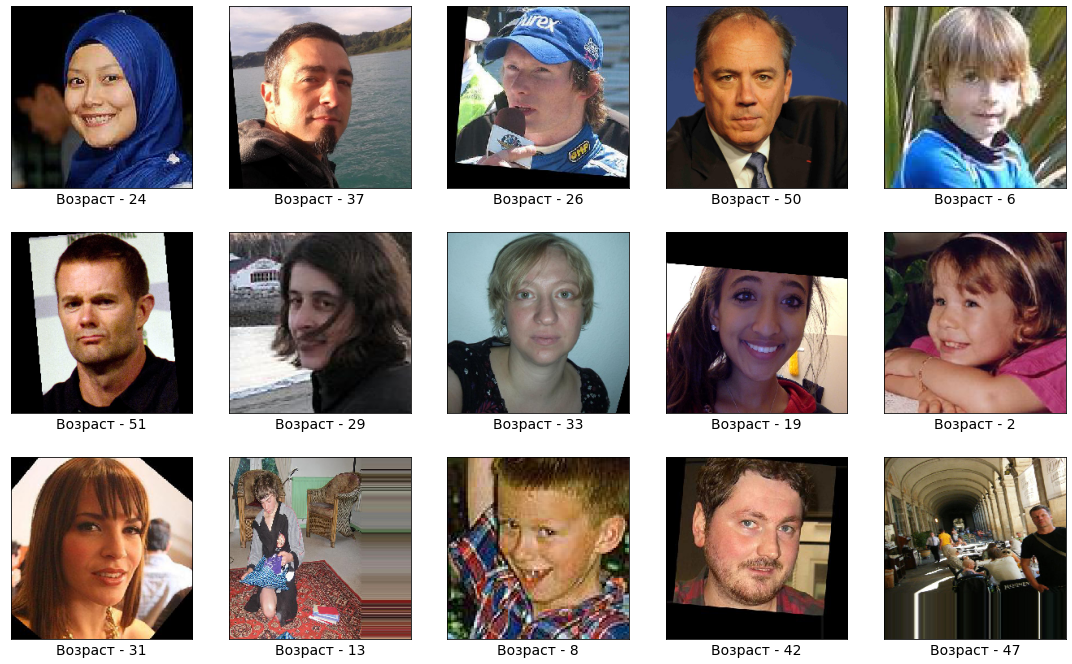

In [32]:
fig = plt.figure(figsize=(15, 10))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.xlabel(f'Возраст - {age[i]}', fontsize=14)
    plt.tight_layout()
    ax.set(xticks=[], yticks=[])

По фотографиям мы видем, что большинство из них подготовлены и на них изображено лицо человека. Есть фотографии, на которых человек изображен в полный рост, что может негативно сказаться на работе модели.

### Вывод

Датасет состоит из 7591 фотографий, для каждой фотографии указан возраст чесловека на фото.
Из распеделения возраста по датасету видно, что больше всего фотографий людей в возрасте от 17 до 35 лет, медианный возраст составляет - 29 лет, самый маленький возраст - 1 год, самый большой 100 лет.

Были выаедены 15 фотографий и было обраружено, что большинство фотографий подготовлены и на них изображено лицо человека. Есть фотографии, на которых человек изображен в полный рост, что может негативно сказаться на работе модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
# Подключим необходимые библиотеки для обучения модели
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50

# Создадим переменную с оптимизатором
optimizer = Adam(0.0001)


def load_train(path):
    '''
    Функция загрузки тренировочных данных
    '''
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1/255,
        validation_split=0.25)
    
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123
    )

    return train_data


def load_test(path):
    '''
    Функция загрузки тестовых данных
    '''
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        rescale=1/255,
        validation_split=0.25
    )
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123
    )

    return test_data

    
def create_model(input_shape):
    '''
    Функция создания модели.
    Для решения задачи выбрана модель ResNet50
    '''
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    model = Sequential() 
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae']
    )
    
    return model


def train_model(
    model, train_data, test_data, batch_size=None,
    epochs=15, steps_per_epoch=None, validation_steps=None):
    '''
    Функция тренировки созданной модели
    '''
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

```

```

# Результат работы модели.

Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-07-25 14:18:16.636705: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-25 14:18:17.406967: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 72s - loss: 251.9581 - mae: 11.3229 - val_loss: 1169.4323 - val_mae: 29.6152
Epoch 2/15
178/178 - 38s - loss: 60.1039 - mae: 5.8800 - val_loss: 1125.6169 - val_mae: 28.9017
Epoch 3/15
178/178 - 38s - loss: 30.1202 - mae: 4.1876 - val_loss: 402.1344 - val_mae: 15.0574
Epoch 4/15
178/178 - 37s - loss: 18.9184 - mae: 3.3282 - val_loss: 112.3365 - val_mae: 8.1377
Epoch 5/15
178/178 - 37s - loss: 14.3581 - mae: 2.9208 - val_loss: 90.9986 - val_mae: 7.4126
Epoch 6/15
178/178 - 37s - loss: 11.8168 - mae: 2.6207 - val_loss: 108.6840 - val_mae: 7.8654
Epoch 7/15
178/178 - 37s - loss: 10.1695 - mae: 2.4599 - val_loss: 71.9735 - val_mae: 6.3542
Epoch 8/15
178/178 - 37s - loss: 9.5095 - mae: 2.3468 - val_loss: 72.4392 - val_mae: 6.5130
Epoch 9/15
178/178 - 37s - loss: 9.2595 - mae: 2.3096 - val_loss: 74.0735 - val_mae: 6.4506
Epoch 10/15
178/178 - 37s - loss: 8.4335 - mae: 2.1934 - val_loss: 77.1493 - val_mae: 6.6162
Epoch 11/15
178/178 - 37s - loss: 7.5944 - mae: 2.0761 - val_loss: 75.8345 - val_mae: 6.3788
Epoch 12/15
178/178 - 38s - loss: 6.8034 - mae: 1.9279 - val_loss: 69.8054 - val_mae: 6.1861
Epoch 13/15
178/178 - 39s - loss: 5.8033 - mae: 1.8112 - val_loss: 68.6599 - val_mae: 6.1714
Epoch 14/15
178/178 - 39s - loss: 5.3284 - mae: 1.7418 - val_loss: 65.0655 - val_mae: 6.0390
Epoch 15/15
178/178 - 40s - loss: 5.1268 - mae: 1.7155 - val_loss: 66.8969 - val_mae: 6.1506
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 66.8969 - mae: 6.1506
Test MAE: 6.1506

```

## Анализ обученной модели

Была обучена нейронная сеть для решения задачи опеределения возраста покупателя (задача регресии). Для решения данной задачи была выбрана архитектура нейронной сети ResNet50. Нейроная сеть обучалась на протяжении 15 эпох, в результате обучения на тестовой выборке получено значение MAE - 6.1506. По логам обучения нейронной сети видно, что можно было обучать модель 5 - 7 эпох, чтобы получить MAE менее 8.